In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Non-Negative Matrix Factorization for Topic Modeling

## Objectives

* Identify weaknesses with SVD for topic modeling
* Define NMF
* Describe alternating least squares
* Identify strenghts and weaknesses of NMF

## Introduction

We already have some experience doing matrix decomposition for topic modelling.

Here's a familiar example, where we use singular value decomposition to decompose a movie ratings matrix:

In [2]:
rating_matrix = np.array([
              [1, 2, 2, 0, 0],
              [3, 5, 5, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

movies = ['TheMatrix', 'Alien', 'StarWars', 'Casablanca', 'Titanic']
users = ['Alice', 'Juan', 'Riya', 'Dan', 'Emily', 'Angel', 'Omar']
ratings_df = pd.DataFrame(rating_matrix, index=users, columns=movies)
ratings_df

,TheMatrix,Alien,StarWars,Casablanca,Titanic
Alice,1,2,2,0,0
Juan,3,5,5,0,0
Riya,4,4,4,0,0
Dan,5,5,5,0,0
Emily,0,2,0,4,4
Angel,0,0,0,5,5
Omar,0,1,0,2,2


In [3]:
U, S, VT = np.linalg.svd(ratings_df, full_matrices=False)
U = -U   #flip, because sign indeterminancy
VT = -VT

In [4]:
n_topics = len(S)

Here's a matrix $U\Sigma$, modeling user topics.

In [5]:
users = pd.DataFrame(U@np.diag(S), index=ratings_df.index, 
                     columns=[f"topic{i+1}" for i in range(len(S))])
users

,topic1,topic2,topic3,topic4,topic5
Alice,2.935342,-0.224600,-0.515255,-0.260453,0.0
Juan,7.589530,-0.608933,-0.898022,-0.470940,0.0
Riya,6.875388,-0.638936,0.529955,0.199867,0.0
Dan,8.594235,-0.798670,0.662444,0.249834,0.0
Emily,1.727579,5.682162,-0.667249,0.532246,0.0
Angel,0.610656,6.987917,0.707563,-0.543570,0.0
Omar,0.863789,2.841081,-0.333625,0.266123,0.0


And our matrix V, modeling movie topics.

In [6]:
movies = pd.DataFrame(VT.T, index=ratings_df.columns, 
                     columns=[f"topic{i+1}" for i in range(len(S))])
movies

,topic1,topic2,topic3,topic4,topic5
TheMatrix,0.502352,-0.094868,0.780233,0.360387,-0.000000e+00
Alien,0.619527,0.045914,-0.616650,0.483551,-7.248355e-17
StarWars,0.596968,-0.110780,-0.031094,-0.793971,7.248355e-17
Casablanca,0.061066,0.698792,0.070756,-0.054357,7.071068e-01
Titanic,0.061066,0.698792,0.070756,-0.054357,-7.071068e-01


SVD does an okay job at topic modeling, but there's three main problems.

* Both $U$ and $V$ are constrained to be orthogonal matrices, which is an unnecessary contraint.
* Values in $U$ and $V^T$ can be negative, which is weird and hard to interpret. For example, suppose a latent feature is the genre 'Science fiction'. This feature can be positive (makes sense), zero (makes sense), or negative (what does that mean?).
* SVD forces us to fill in missing values, and SVD models those missing values.

How can we avoid these?


## Non-negative Matrix Factorization (NMF)



Suppose we have a matrix $V \in \mathbb{R}^{m \times n}$. With NMF, we try to write it as the product of two smaller matrices, $W \in \mathbb{R}^{m \times r}$ and $H \in \mathbb{R}^{r \times n}$, 

$$ V = W H$$

or, to be more graphical,

$$\begin{bmatrix}
    v_{11}       & v_{12} & v_{13} & \dots & v_{1n} \\
    v_{21}       & v_{22} & v_{23} & \dots & v_{2n} \\
    v_{31}       & v_{32} & v_{33} & \dots & v_{3n} \\
    v_{41}       & v_{42} & v_{43} & \dots & v_{4n} \\
    \vdots       & \vdots & \vdots & \ddots& \vdots \\
    v_{m1}       & v_{m2} & v_{m3} & \dots & v_{mn}
\end{bmatrix}
=
\begin{bmatrix}
    w_{11}       & \dots & w_{1r} \\
    w_{21}       & \dots & w_{2r} \\
    w_{31}       & \dots & w_{3r} \\
    w_{41}       & \dots & w_{4r} \\
    \vdots       & \ddots& \vdots \\
    w_{m1}       & \dots & w_{mr}
\end{bmatrix}
\cdot
\begin{bmatrix}
    h_{11}       & h_{12} & h_{13} & \dots & h_{1n} \\
    \vdots       & \vdots & \vdots & \ddots& \vdots \\
    h_{r1}       & h_{r2} & h_{r3} & \dots & h_{rn}
\end{bmatrix}
$$

with the constraint that all $w_{ik} \ge 0$ and $h_{kj} \ge 0$.

In general, this isn't possible, but we'll try to do the best we can, minimizing

$$||V - WH||^2 = \sum_{ij} (V_{ij} - \sum_k W_{ik} H_{kj})^2$$

again with the constraint that the components are greater than zero.

Note that the number of topics $r$ is a hyperparameter; we can choose how many topics we want.

**Question** What would the value of $r$ have to do with the bias-variance tradeoff?

**Question** What would we lose compared to SVD?

## Solving NMF

There are a couple approaches to solving NMF.

**Alternating Least Squares** involves solving first for one matrix while holding the other constant, that the other, back and forth until in converges.

**Stocastic Gradient Descent** minimizes the components of the matrices using the previously discussed algorithm.

## Alternating Least Squares

First, some review.

### Exact solution for a system of linear equations
Take a system of linear equations:
* $x_1 + 2x_2 = 7$
* $-3x_1 + 4x_2 = -9$

Which we can express using matrix notation

$$ Ax = b$$

$$ \begin{bmatrix} 1 & 2 \\ -3 & 4 \end{bmatrix} \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] = \left[ \begin{array}{cc} 7 \\ -9 \end{array} \right] $$

The solution is to `x` is

$$ Ax = b$$
$$ A^{-1}Ax = A^{-1}b$$
$$ x = A^{-1}b$$

There are two unknowns ($x_1$ and $x_2$) and two equations so (usually) there is one solution.

In [7]:
A = np.array([[1,2],[-3,4]])
b = np.array([7,-9])

np.linalg.inv(A) @ b

array([4.6, 1.2])

### Least-squares solver

What if we have an overdetermined system of linear equations? E.g.

$$ \begin{bmatrix} 1 & 2 \\ -3 & 4 \\ 1 & -4 \end{bmatrix} \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] = \left[ \begin{array}{cc} 7 \\ -9 \\ 17 \end{array} \right] $$

An exact solution is not guaranteed, so we must do something else.

In [8]:
A = np.array([[1,2],[-3,4],[1,-4]])
b = np.array([7,-9,17])

In [9]:
np.linalg.inv(A)

LinAlgError: Last 2 dimensions of the array must be square

Least Squares dictates that we find the $x$ that minimizes the residual sum of squares (RSS).

(Note: This is the solver we use when doing Linear Regression!)

In [10]:
x_best = np.linalg.lstsq(A, b, rcond=None)[0]
x_best

array([ 2.88, -1.38])

The result isn't perfect 

In [11]:
A @ x_best

array([  0.12, -14.16,   8.4 ])

I challenge you, however, to find an $x$ with a smaller residual sum of squares. You cannot. This is the best.

In [12]:
f"RSS: {sum( (A @ x_best - b)**2 ):0.2f}"

'RSS: 147.92'

### Non-negative least-squares solver

What if you want to constrain the solution to be non-negative?

We have optimizers for that too!

In [13]:
from scipy.optimize import nnls

x_best = nnls(A, b)[0]
x_best

array([4.63636364, 0.        ])

In [14]:
# reconstruct b
A @ x_best

array([  4.63636364, -13.90909091,   4.63636364])

In [15]:
f"RSS: {sum( (A @ x_best - b)**2 ):0.2f}"

'RSS: 182.55'

### Alternating Least Squares

Given matrices $A$ and $B$, our OLS solver will give us a matrix $X$ that minimizes the error $AX = B$.

This can come in handy finding a non-negative matrix decomposition.

We start off with our matrix $V$, which we want to decompose $V = WH$.

In [16]:
np.random.seed(42)

In [17]:
r = 3 #latent features
V = ratings_df.values

m, n = V.shape

#### Pick W at random, then solve for H

We can simply pick random values for $W$ and then solve for $H$...

In [18]:
W = np.random.uniform(0,1, size=(m,r))

Which is tricky because there's generally no inverse for W

In [19]:
np.linalg.inv(W) #ruh roh

LinAlgError: Last 2 dimensions of the array must be square

In [20]:
W.shape #right, because we picked 3 latent topics

(7, 3)

Least squares to the rescue.

In [21]:
H, _, _, _ = np.linalg.lstsq(W, V, rcond=None)

Then set all negative values to zero

In [22]:
H = np.maximum(H,0)
H

array([[0.61431687, 3.48252756, 1.77870526, 2.53885238, 2.53885238],
       [0.        , 0.91386933, 0.49352566, 0.4827349 , 0.4827349 ],
       [3.20529583, 1.33642689, 2.29546736, 0.        , 0.        ]])

The resulting decomposition isn't perfect...

Text(0.5, 1.0, 'reconstruction $WH$')

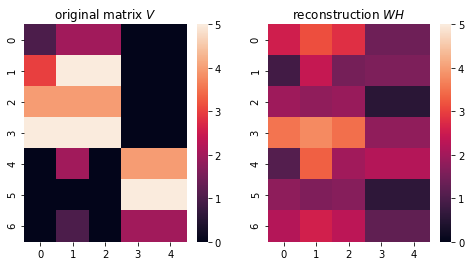

In [23]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

sns.heatmap( V, ax=ax[0], vmin=0, vmax=5)
ax[0].set_title("original matrix $V$")
sns.heatmap( W@H, ax=ax[1], vmin=0, vmax=5)
ax[1].set_title("reconstruction $WH$")

In [24]:
((W@H - V)**2).sum()

137.85858657523485

But it's a start.

#### Hold H steady, solve for W

Next note that $V^T = H^TW^T$

We can use our new $H$ to find a better $W$ than the random guess we started with...

In [25]:
WT, _, _, _ = np.linalg.lstsq(H.T, V.T, rcond=None)
W = np.maximum(0, WT.T)

In [26]:
W @ H

array([[ 1.6259934 ,  5.53083498,  3.78520424,  2.56344996,  2.56344996],
       [ 4.401924  , 13.04292003,  9.20496098,  5.92019396,  5.92019396],
       [ 4.59974882,  7.92500029,  6.53821   ,  3.1731762 ,  3.1731762 ],
       [ 5.74968602,  9.90625037,  8.1727625 ,  3.96647025,  3.96647025],
       [ 2.08977859, 11.84683645,  6.05078637,  8.63664921,  8.63664921],
       [ 3.13889053, 17.79419257,  9.08840586, 12.97242516, 12.97242516],
       [ 1.0448893 ,  5.92341823,  3.02539319,  4.31832461,  4.31832461]])

In [27]:
((W@H - V)**2).sum()

1054.5073417954015

#### Hold W steady, solve for H

In [28]:
H, _, _, _ = np.linalg.lstsq(W, V, rcond=None)
H = np.maximum(H,0)
H

array([[0.00000000e+00, 2.09610049e-01, 0.00000000e+00, 1.04889733e+00,
        1.04889733e+00],
       [0.00000000e+00, 1.96213778e-01, 1.96213778e-01, 1.28961930e-16,
        1.28961930e-16],
       [3.42229326e+00, 1.88859509e+00, 1.88859509e+00, 0.00000000e+00,
        0.00000000e+00]])

In [29]:
((W@H - V)**2).sum()

9.50094641556352

#### Hold H steady, solve for W

In [30]:
WT, _, _, _ = np.linalg.lstsq(H.T, V.T, rcond=None)
W = np.maximum(0, WT.T)

In [31]:
((W@H - V)**2).sum()

1.8756935851087404

#### Hold W steady, solve for H

In [32]:
H, _, _, _ = np.linalg.lstsq(W, V, rcond=None)
H = np.maximum(H,0)
H

array([[0.00000000e+00, 1.56555288e-01, 0.00000000e+00, 1.04824048e+00,
        1.04824048e+00],
       [3.99871802e-16, 2.22232627e-01, 1.85211226e-01, 0.00000000e+00,
        0.00000000e+00],
       [3.42229326e+00, 1.62293177e+00, 2.00093574e+00, 1.88849350e-02,
        1.88849350e-02]])

In [33]:
((W@H - V)**2).sum()

1.6895191726799896

#### Hold H steady, solve for W

In [34]:
WT, _, _, _ = np.linalg.lstsq(H.T, V.T, rcond=None)
W = np.maximum(0, WT.T)

In [35]:
((W@H - V)**2).sum()

1.6912459727144133

It seems that our RSS has converged. Let's take a look at the reconstructed matrix:

Text(0.5, 1.0, 'reconstruction $WH$')

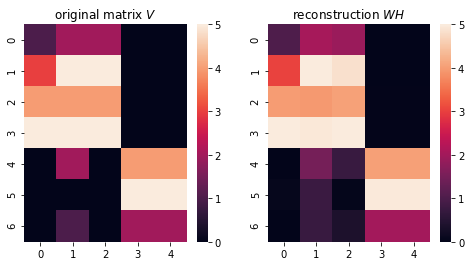

In [36]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

sns.heatmap( V, ax=ax[0], vmin=0, vmax=5)
ax[0].set_title("original matrix $V$")
sns.heatmap( W@H, ax=ax[1], vmin=0, vmax=5)
ax[1].set_title("reconstruction $WH$")

Not bad. We can now inspect the (contrained-positive) topic model for users and movies.

In [37]:
pd.DataFrame(W, index=ratings_df.index)

,0,1,2
Alice,0.000000,7.148051,0.296773
Juan,0.000000,16.619809,0.884995
Riya,0.000000,9.294829,1.165796
Dan,0.000000,11.618537,1.457245
Emily,3.856512,4.034018,0.000000
Angel,4.748285,0.000000,0.019890
Omar,1.928256,2.017009,0.000000


In [38]:
pd.DataFrame(H.T, index=ratings_df.columns)

,0,1,2
TheMatrix,0.000000,3.998718e-16,3.422293
Alien,0.156555,2.222326e-01,1.622932
StarWars,0.000000,1.852112e-01,2.000936
Casablanca,1.048240,0.000000e+00,0.018885
Titanic,1.048240,0.000000e+00,0.018885


### General vs. non-negative least squares solver

Non-negative least squares solver:
    
 * Returns result with least squares error given non-negativity constraint
 * While alternating, converges to a local minimum
 * Orders of magnitude slower than general least squares solver

General least squares solver:
    
 * Returns result with least squares error with no constraints
 * While alternating, converges to a stationary point (saddle point or minimum)
 * Much much faster
 * Have to clip the matrix at every iteration to ensure non-negativity
   
In industry the general least squares solver is commonly used. The tradeoff between speed and strong convergence seems to be worth it. For more information check out: http://users.wfu.edu/plemmons/papers/BBLPP-rev.pdf

### From `sklearn`

In [39]:
from sklearn.decomposition import NMF

In [40]:
nmf = NMF(n_components=3)

In [41]:
W = nmf.fit_transform(V)
H = nmf.components_

In [42]:
((W@H - V)**2).sum() #pretty good

1.5038136860096203

In [43]:
pd.DataFrame(W, index=ratings_df.index)

,0,1,2
Alice,0.704652,0.000000,0.209972
Juan,1.733010,0.000000,0.608938
Riya,1.294738,0.001815,0.755987
Dan,1.618423,0.002269,0.944984
Emily,0.393512,1.839836,0.000000
Angel,0.000000,2.278843,0.000000
Omar,0.196756,0.919918,0.000000


In [44]:
pd.DataFrame(H.T, index=ratings_df.columns)

,0,1,2
TheMatrix,0.000000,0.000031,5.206784
Alien,3.022714,0.197832,0.000000
StarWars,1.849307,0.000000,2.314512
Casablanca,0.000000,2.185120,0.000000
Titanic,0.000000,2.185120,0.000000


## Additional notes

We can use **regularization** with NMF, adding a terms cost for large values in $W$ and $H$, with either an L1 or L2 penelty.

Some implementations (not sklearn) allow ignoring **missing values** in the original matrix. In these implementations, RSS is computed on non-missing items in the matrix $V$. The items in $WH$ corresponding to missing items in $V$ would correspond to hypothetical ratings; high ones would be recommendations.

## NMF faces

In [45]:
from sklearn.datasets import fetch_olivetti_faces

In [68]:
np.random.seed(42)
faces = fetch_olivetti_faces(shuffle=True).data

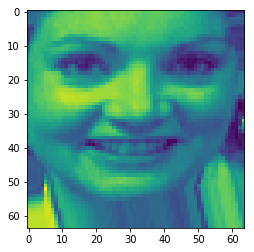

In [69]:
plt.imshow( faces[2].reshape(64,-1) )

In [116]:
V = faces
m, n = V.shape
r = 25

In [142]:
W = np.random.uniform(0,1, size=(m,r))


for i in range(100):
    H, _, _, _ = np.linalg.lstsq(W, V, rcond=None)
    H = np.maximum(0,H)*0.9

    WT, _, _, _ = np.linalg.lstsq(H.T, V.T, rcond=None)
    W = np.maximum(0, WT.T)*0.9
    
    print( "iter", i, ",", "RSS", ((W@H - V)**2).sum() )

iter 0 , RSS 28603.655946645078
iter 1 , RSS 15300.431203143624
iter 2 , RSS 13844.389670018709
iter 3 , RSS 13057.652581790759
iter 4 , RSS 12678.58720415434
iter 5 , RSS 12549.008881932634
iter 6 , RSS 12552.588254662664
iter 7 , RSS 12650.912859376664
iter 8 , RSS 12876.318479694011
iter 9 , RSS 13235.420436837601
iter 10 , RSS 13628.152442571576
iter 11 , RSS 13886.833424255528
iter 12 , RSS 13902.33179604971
iter 13 , RSS 13760.18627365371
iter 14 , RSS 13559.197733865454
iter 15 , RSS 13345.167856834136
iter 16 , RSS 13158.39943485212
iter 17 , RSS 13025.973671975187
iter 18 , RSS 12941.325806933784
iter 19 , RSS 12920.332120857154
iter 20 , RSS 12894.698378775156
iter 21 , RSS 12824.665146587884
iter 22 , RSS 12731.857318619364


KeyboardInterrupt: 

In [143]:
V_reconstruct = W@H

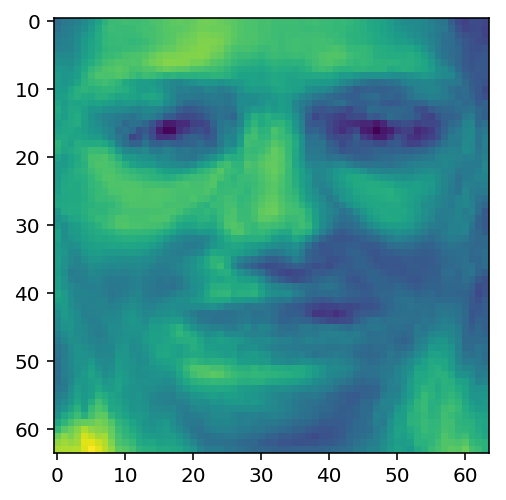

In [202]:
%config InlineBackend.figure_format = 'retina'
plt.imshow( V_reconstruct[2].reshape(64,-1) )

In [203]:
W.shape #samples, latent features

(400, 25)

In [204]:
H.shape #latent features, features

(25, 4096)

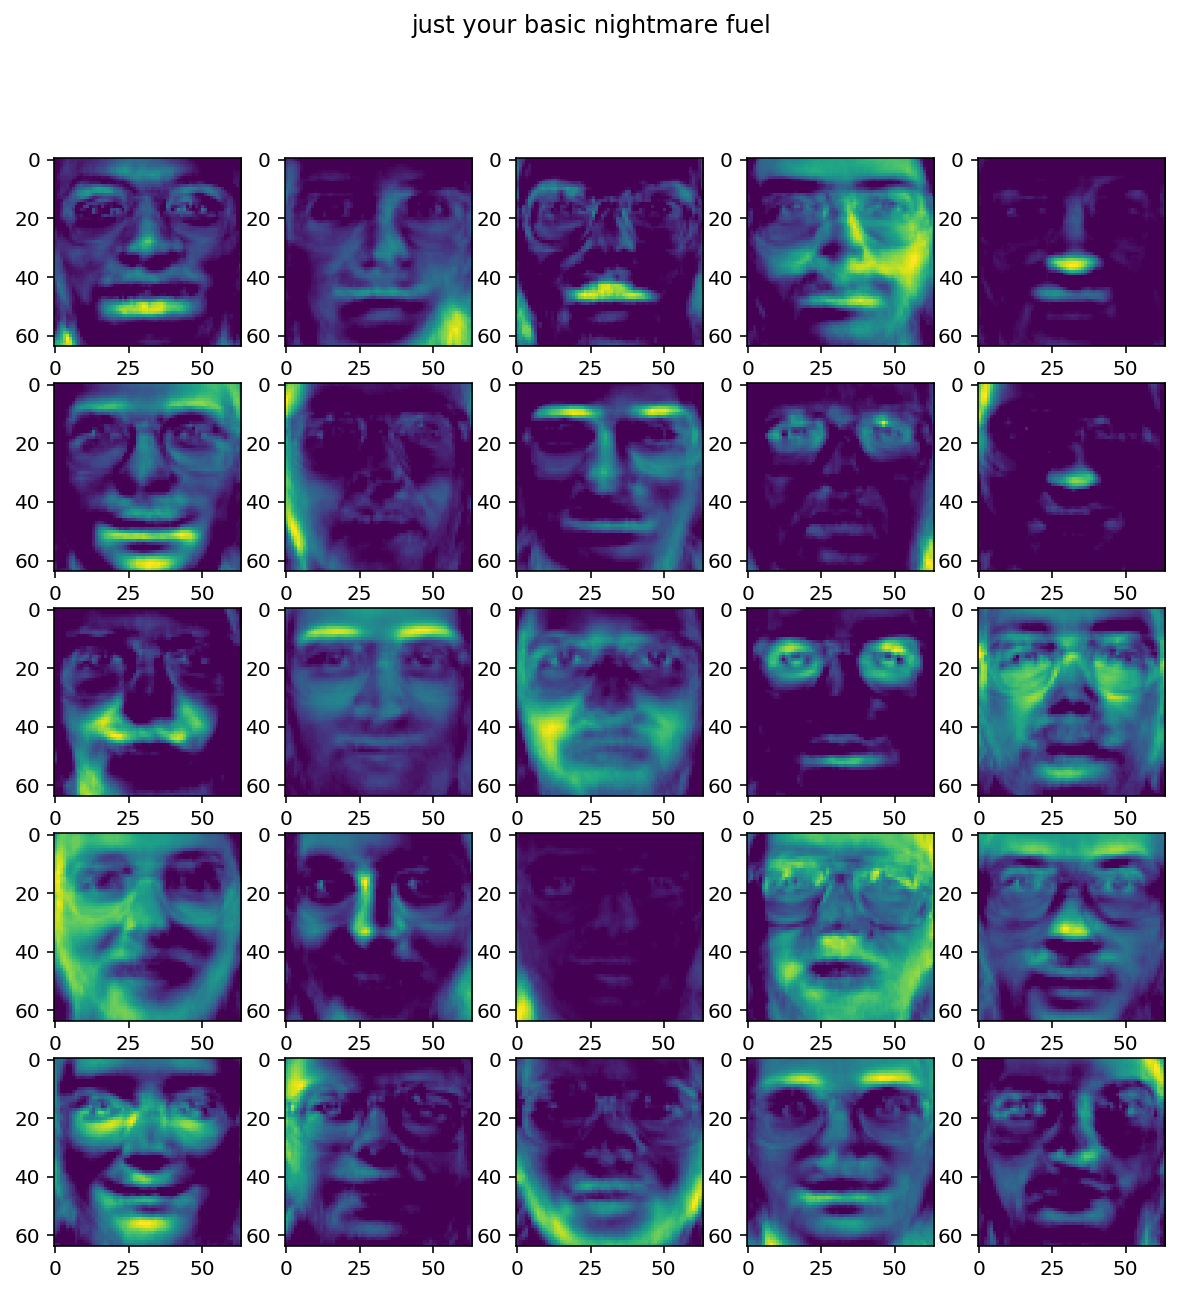

In [205]:
nrows, ncols = 5,5
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))

fig.suptitle("just your basic nightmare fuel")
for i in range(ncols):
    for j in range(nrows):
        ax = axs[i][j]
        ax.imshow( H[i*ncols+j].reshape(64,-1))

In [206]:
face = np.zeros(25)
face[3] = 1# lit from the right
face[22] = 0.09 # lit from the bottom
#face[4] = 0.3 # long nose

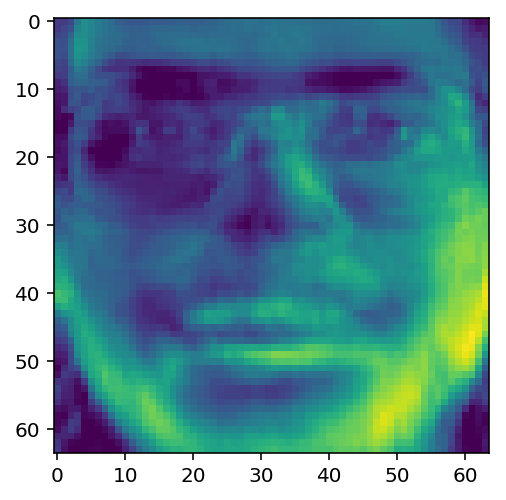

In [207]:
# lit from the lower right
plt.imshow( (H.T @ face).reshape(64,-1) )